# Turismo de los Alpes

Jose Daniel Fuentes - jd.fuentes

El Ministerio de Comercio, Industria y Turismo de Colombia, la Asociación Hotelera y
Turística de Colombia – COTELCO, cadenas hoteleras de la talla de Hilton, Hoteles Estelar,
Holiday Inn y hoteles pequeños ubicados en diferentes municipios de Colombia están
interesados en analizar las características de sitios turísticos que los hacen atractivos para
turistas locales o de otros países, ya sea para ir a conocerlos o recomendarlos. De igual
manera, quieren comparar las características de dichos sitios, con aquellos que han
obtenido bajas recomendaciones y que están afectando el número de turistas que llegan a
ellos. Adicionalmente, quieren tener un mecanismo para determinar la calificación que
tendrá un sitio por parte de los turistas y así, por ejemplo, aplicar estrategias para identificar
oportunidades de mejora que permitan aumentar la popularidad de los sitios y fomentar el
turismo.
Esos actores de turismo prepararon dos conjuntos de datos con reseñas de sitios turísticos.
Cada reseña tiene una calificación según el sentimiento que tuvo el turista al visitarlo. Estos
actores quieren lograr un análisis independiente de los conjuntos de datos y al final del
proyecto discutir sobre los grupos de científicos de datos e ingenieros de datos que
acompañarán el desarrollo real de este proyecto.

## 0. Cargar Librerias

In [203]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pickle

from joblib import dump, load
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from collections import Counter

Cargar set de datos en el data frame:

In [100]:
reviews_df = pd.read_csv("tipo1_entrenamiento_estudiantes.csv")
reviews_df

Review  Class
0     Nos alojamos en una casa alquilada en la ciuda...      4
1     La comida está bien, pero nada especial. Yo te...      3
2     En mi opinión, no es una como muchos usuarios ...      3
3     esta curiosa forma que asemeja una silla de mo...      4
4     Lo mejor era la limonada. Me gusto la comida d...      2
...                                                 ...    ...
7870  El motivo de mi estancia fue porque vine a un ...      3
7871  Es difícil revisar el castillo porque apenas p...      3
7872  Si vas a Mérida no puedes perderte de este lug...      5
7873  Este imperdible sitio, que lleva el nombre del...      5
7874  Festejando Dia del Amor y Amistad\n\nTe remont...      3

[7875 rows x 2 columns]

## 1. Entendimiento de datos

Al cargar el dataset podemos observar que existen 2 columnas una con el Review o comentario acerca del hotel o lugar en donde estuvieron los usuarios y la segunda con una calificacion dada al sitio. A continuacion vamos a evaluar los requerimientos de completitud, unicidad, consistencia, validez asi como ver que tan sesgado pueden estar los datos seleccionados para apartir de ello identificar las actividades de preparación que requieren los datos.

Podemos observar que exiten 7875 registros en los datos con 2 columnas asociadas la primera, los reviews y la segunda el class que se puede definir como la calificacion dada al sitio

In [101]:
reviews_df

Review  Class
0     Nos alojamos en una casa alquilada en la ciuda...      4
1     La comida está bien, pero nada especial. Yo te...      3
2     En mi opinión, no es una como muchos usuarios ...      3
3     esta curiosa forma que asemeja una silla de mo...      4
4     Lo mejor era la limonada. Me gusto la comida d...      2
...                                                 ...    ...
7870  El motivo de mi estancia fue porque vine a un ...      3
7871  Es difícil revisar el castillo porque apenas p...      3
7872  Si vas a Mérida no puedes perderte de este lug...      5
7873  Este imperdible sitio, que lleva el nombre del...      5
7874  Festejando Dia del Amor y Amistad\n\nTe remont...      3

[7875 rows x 2 columns]

In [102]:
reviews_df.shape

(7875, 2)

### Unicidad

Se encontraron 109 registros duplicados por lo que se procedera a eliminar estos registros ya que es muy minima la cantidad de registros duplicados.

In [103]:
reviews_df.duplicated(keep = False).sum()

109

### Completitud

Podemos ver que los datos estan completos sin ningun campo faltante o nulo por lo tanto no tendremos que hacer eliminacion de datos nulos dentro del set de datos

In [104]:
(reviews_df.isnull().sum() / reviews_df.shape[0]).sort_values(ascending = False)

Review    0.0
Class     0.0
dtype: float64

### Consistencia

Podemos ver que los datos no presentan problemas de consistencia en cuanto al tipo de variables manejados dentro de cada columna ya que tienen los tipos de atributos que deberian tener

In [105]:
reviews_df.dtypes

Review    object
Class      int64
dtype: object

### Validez

Corraboramos una vez mas que la validez en el set de datos no se incumple ya que las calificaciones tienen que ser menores o iguales a 5 y al revisar esto no hay ninguna review que exceda esa calificacion asi mismo no existe como tal un formato para las reviews por lo que cualquier tipo de string es aceptado

In [106]:
check_validez = reviews_df.loc[reviews_df['Class'] > 5, 'Review']
check_validez

Series([], Name: Review, dtype: object)

### Sesgo

Podemos ver que existe un poco de sesgo en los datos ya que hay una diferencia muy grande en cuanto la cantidad de reviews de calificacion 5 vs los de 1, 2, 3. Sin embargo no podemos solucionar esto puesto que requeririamos generar mas reviews para completar el dataset y que no haya tanto sesgo entre las calificaciones

In [107]:
reviews_df['Class'].value_counts()

Class
5    2350
4    1971
3    1568
2    1173
1     813
Name: count, dtype: int64

## 2. Limpieza de datos

Para la limpieza de datos primero se eliminaran los datos duplicados y despues se procedera a eliminar los simbolos puesto que estos no representan mucha informacion, sin embargo se mantendran los emoticonos puesto que estos son una forma de expresar sentimientos

In [108]:
reviews_df.drop_duplicates()

Review  Class
0     Nos alojamos en una casa alquilada en la ciuda...      4
1     La comida está bien, pero nada especial. Yo te...      3
2     En mi opinión, no es una como muchos usuarios ...      3
3     esta curiosa forma que asemeja una silla de mo...      4
4     Lo mejor era la limonada. Me gusto la comida d...      2
...                                                 ...    ...
7870  El motivo de mi estancia fue porque vine a un ...      3
7871  Es difícil revisar el castillo porque apenas p...      3
7872  Si vas a Mérida no puedes perderte de este lug...      5
7873  Este imperdible sitio, que lleva el nombre del...      5
7874  Festejando Dia del Amor y Amistad\n\nTe remont...      3

[7804 rows x 2 columns]

In [109]:
reviews_df.duplicated().sum()

71

In [110]:
def preprocessor(text):
  text = re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
  text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
  return text

Como puedes ver aquí, el texto puede contener puntuación y otros caracteres que no son letras. Ahora vamos a eliminar todos los signos de puntuación excepto los emoticonos, como :), ya que estos son ciertamente útiles para el análisis de sentimientos.

In [111]:
reviews_df['Review'] = reviews_df['Review'].apply(preprocessor)

Luego construiremos un bag of words basado en el numero de veces que se repite una palabra en el documento

In [112]:
count = CountVectorizer()
bag = count.fit_transform(reviews_df.Review)
count.vocabulary_

{'nos': 17060,
 'alojamos': 1622,
 'en': 9369,
 'una': 24746,
 'casa': 4602,
 'alquilada': 1647,
 'la': 14411,
 'ciudad': 5209,
 'amurallada': 1849,
 'parecía': 18053,
 'tan': 23566,
 'segura': 22297,
 'como': 5665,
 'cualquier': 6897,
 'otra': 17737,
 'gran': 12047,
 'con': 5886,
 'un': 24744,
 'montón': 16428,
 'de': 7271,
 'buenos': 3838,
 'restaurantes': 21427,
 'tiendas': 23963,
 'vida': 25349,
 'nocturna': 17011,
 'lugar': 15142,
 'para': 17985,
 'grupo': 12154,
 'intereses': 13869,
 'variados': 25022,
 'no': 17003,
 'estoy': 10407,
 'seguro': 22302,
 'que': 20118,
 'le': 14575,
 'traiga': 24320,
 'los': 15098,
 'niños': 16999,
 'aquí': 2297,
 'sólo': 23481,
 'porque': 19194,
 'hay': 12503,
 'mucho': 16575,
 'hacer': 12400,
 'ellos': 9212,
 'asegúrate': 2586,
 'aventurarse': 2994,
 'fuera': 11599,
 'pero': 18586,
 'algunos': 1544,
 'también': 23561,
 'es': 9915,
 'alojarse': 1630,
 'comida': 5639,
 'está': 10498,
 'bien': 3496,
 'nada': 16783,
 'especial': 10137,
 'yo': 25833,
 '

Cuando estamos analizando datos de texto, a menudo nos encontramos con palabras que aparecen en varios documentos de ambas clases. Estas palabras que ocurren con frecuencia típicamente no contienen información útil o discriminatoria. La frecuencia de término-inversa de frecuencia de documento (tf-idf), que puede utilizarse para reducir el peso de estas palabras que ocurren con frecuencia en los vectores de características, se define como el producto de la frecuencia del término y la frecuencia inversa del documento.

In [113]:
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)

In [114]:
np.set_printoptions(precision=2)
print(tfidf.fit_transform(count.fit_transform(reviews_df.Review)).toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [115]:
reviews_df

Review  Class
0     nos alojamos en una casa alquilada en la ciuda...      4
1     la comida está bien pero nada especial yo tení...      3
2     en mi opinión no es una como muchos usuarios r...      3
3     esta curiosa forma que asemeja una silla de mo...      4
4     lo mejor era la limonada me gusto la comida de...      2
...                                                 ...    ...
7870  el motivo de mi estancia fue porque vine a un ...      3
7871  es difícil revisar el castillo porque apenas p...      3
7872  si vas a mérida no puedes perderte de este lug...      5
7873  este imperdible sitio que lleva el nombre del ...      5
7874  festejando dia del amor y amistad te remonta a...      3

[7875 rows x 2 columns]

### Procesando documentos en tokens

Tokenizar documentos significa dividirlos en palabras individuales al dividir los documentos limpios en sus caracteres de espacio en blanco.

In [116]:
porter = PorterStemmer()

def tokenizer(text):
  text = text.split()
  return ' '.join([i for i in text if i not in stop and len(i) > 2])

def tokenizer_porter(text):
  return ' '.join([porter.stem(word) for word in text.split()])

nltk.download('stopwords')
stop = stop = set(stopwords.words('spanish'))
reviews_df['Review'] = reviews_df['Review'].apply(preprocessor)
reviews_df['Review'] = reviews_df['Review'].apply(tokenizer)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [117]:
reviews_df

Review  Class
0     alojamos casa alquilada ciudad amurallada pare...      4
1     comida bien especial mejor comida mexcan unido...      3
2     opinión usuarios reclaman gran paladar parece ...      3
3     curiosa forma asemeja silla montar ahi nombre ...      4
4           mejor limonada gusto comida mundo sosa frío      2
...                                                 ...    ...
7870  motivo estancia vine congreso medico hospedaro...      3
7871  difícil revisar castillo apenas podíamos camin...      3
7872  vas mérida puedes perderte lugar nueva sucursa...      5
7873  imperdible sitio lleva nombre conquistador joy...      5
7874  festejando dia amor amistad remonta restaurant...      3

[7875 rows x 2 columns]

## 3. Modelos

### 3.1 Entrenando modelo logistico de Regresion para la clasificacion del documento.

Se utilizará un modelo de regresión logística para clasificar las reseñas de lugares en reseñas de clase 5 hasta clase 1  basadas en el modelo de bolsa de palabras. Primero, dividiremos el DataFrame de documentos de texto limpios en 7875 documentos para entrenamiento y 7875 documentos para pruebas.

In [118]:
X_train = reviews_df.loc[:7875, 'Review'].values
y_train = reviews_df.loc[:7875, 'Class'].values
X_test = reviews_df.loc[:7875, 'Review'].values
y_test = reviews_df.loc[:7875, 'Class'].values

In [119]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)
param_grid = [{'vect__ngram_range': [(1,1)],
                'vect__stop_words': [stop, None],
                'vect__tokenizer': [tokenizer,
                                    tokenizer_porter],
                'clf__penalty': ['l1', 'l2'],
                'clf__C': [1.0, 10.0, 100.0]},
               {'vect__ngram_range': [(1,1)],
                'vect__stop_words': [stop, None],
                'vect__tokenizer': [tokenizer,
                                    tokenizer_porter],
                'vect__use_idf':[False],
                'vect__norm':[None],
                'clf__penalty': ['l1', 'l2'],
                'clf__C': [1.0, 10.0, 100.0]}
              ]
lr_tfidf = Pipeline([('vect', tfidf),
                      ('clf',
                       LogisticRegression(random_state=0,
                                          solver='liblinear'))])
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                            scoring='accuracy',
                            cv=5, verbose=2,
                            n_jobs=1)
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words={'estaré', 'estaréis', 'nuestras', 'tengan', 'ella', 'estaba', 'mío', 'cuando', 'serán', 'tuviésemos', 'estado', 'esta', 'vuestros', 'estuviéramos', 'mía', 'una', 'cual', 'la', 'tengamos', 'te', 'poco', 'estaban', 'hubieron', 'vuestras', 'hayan', 'qué', 'nada', 'habrían', 'estad', 'fueseis', 'sí', 'sentido', 'su', 'han', 'estuviese', 'estabais', 'mi', 'todo', 'será', 'haya', 'ante', 'tendrá', 'nuestra', 'serás', 'habíamos', 'tanto', 'esos', 'estar', 'que', 'suyas', 'se', 'eras', 'les', 'los', 'nos', 'estaría', 'estuvieran', 'tendríamos', 'quien', 'estuvieseis', 'fuiste', 'estando', 'estuvisteis', 'sentidos', 'ellas', 'habríamos', 'otro', 'vuestra', 'fui', 'el', 'tuvierais', 'tu', 'somos', 'desde', 'tendría', 'tendréis', 'con', 'estuvieron', 'habrá', 'suyos', 'sois', 'tenidos', 'he', 'fuese', 'eran', 'fuesen', 'estén', 'hubiera', 'hubiesen', 'tuv

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   6.5s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=  12.8s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=  12.5s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=  12.7s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=  12.4s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=  12.5s
[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words={'estaré', 'estaréis', 'nuestras', 'tengan', 'ella', 'estaba', 'mío', 'cuando', 'serán', 'tuviésemos', 'estado', 'esta', 'vuestros', 'estuviéramos', 'mía', 'una', 'cual', 'la', 'tengamos', 'te', 'poco', 'estaban', 'hubieron', 'vuestras', 'hayan', 'qué', 'nada', 'habrían', 'estad', 'fueseis', 'sí', 'sentido', 'su', 'han', 'estuviese', 'estabais', 'mi', 'todo', 'será', 'haya', 'ante', 'tendrá', 'nuestra', 'serás', 'habíamos', 'tanto', 'esos', 'estar', 'que', 'suyas', 'se', 'eras', 'les', 'los', 'nos', 'estaría', 'estuvieran', 'tendríamos', 'quien', 'estuvieseis', 'fuiste', 'estando', 'estuvisteis', 'sentidos', 'ellas', 'habríamos', 'otro', 'vuestra', 'fui', 'el', 'tuvierais', 'tu', 'somos', 'desde', 'tendría', 'tendréis', 'con', 'estuvieron',

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=   6.3s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=   6.4s
[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words={'estaré', 'estaréis', 'nuestras', 'tengan', 'ella', 'estaba', 'mío', 'cuando', 'serán', 'tuviésemos', 'estado', 'esta', 'vuestros', 'estuviéramos', 'mía', 'una', 'cual', 'la', 'tengamos', 'te', 'poco', 'estaban', 'hubieron', 'vuestras', 'hayan', 'qué', 'nada', 'habrían', 'estad', 'fueseis', 'sí', 'sentido', 'su', 'han', 'estuviese', 'estabais', 'mi', 'todo', 'será', 'haya', 'ante', 'tendrá', 'nuestra', 'serás', 'habíamos', 'tanto', 'esos', 'estar', 'que', 'suyas', 'se', 'eras', 'les', 'los', 'nos', 'estaría', 'estuvieran', 'tendríamos', 'quien', 'estuvieseis', 'fuiste', 'estando', 'estuvisteis', 'sentidos', 'ellas', 'habríamos', 'otro', 'vuestra', 'fui', 'el', 'tuvierais', 'tu', 'somos', 'desde', 'tendría', 'tendréis', 'con', 'estuvieron'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=  14.0s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=  13.6s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=  14.8s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=  13.3s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=  16.3s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=  19.1s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=  21.2s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=  20.2s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=  18.7s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=  20.8s
[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words={'estaré', 'estaréis', 'nuestras', 'tengan', 'ella', 'estaba', 'mío', 'cuando', 'serán', 'tuviésemos', 'estado', 'esta', 'vuestros', 'estuviéramos', 'mía', 'una', 'cual', 'la', 'tengamos', 'te', 'poco', 'estaban', 'hubieron', 'vuestras', 'hayan', 'qué', 'nada', 'habrían', 'estad', 'fueseis', 'sí', 'sentido', 'su', 'han', 'estuviese', 'estabais', 'mi', 'todo', 'será', 'haya', 'ante', 'tendrá', 'nuestra', 'serás', 'habíamos', 'tanto', 'esos', 'estar', 'que', 'suyas', 'se', 'eras', 'les', 'los', 'nos', 'estaría', 'estuvieran', 'tendríamos', 'quien', 'estuvieseis', 'fuiste', 'estando', 'estuvisteis', 'sentidos', 'ellas', 'habríamos', 'otro', 'vuestra', 'fui', 'el', 'tuvierais', 'tu', 'somos', 'desde', 'tendría', 'tendréis', 'con', 'estuvieron

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=   6.8s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=   7.4s
[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words={'estaré', 'estaréis', 'nuestras', 'tengan', 'ella', 'estaba', 'mío', 'cuando', 'serán', 'tuviésemos', 'estado', 'esta', 'vuestros', 'estuviéramos', 'mía', 'una', 'cual', 'la', 'tengamos', 'te', 'poco', 'estaban', 'hubieron', 'vuestras', 'hayan', 'qué', 'nada', 'habrían', 'estad', 'fueseis', 'sí', 'sentido', 'su', 'han', 'estuviese', 'estabais', 'mi', 'todo', 'será', 'haya', 'ante', 'tendrá', 'nuestra', 'serás', 'habíamos', 'tanto', 'esos', 'estar', 'que', 'suyas', 'se', 'eras', 'les', 'los', 'nos', 'estaría', 'estuvieran', 'tendríamos', 'quien', 'estuvieseis', 'fuiste', 'estando', 'estuvisteis', 'sentidos', 'ellas', 'habríamos', 'otro', 'vuestra', 'fui', 'el', 'tuvierais', 'tu', 'somos', 'desde', 'tendría', 'tendréis', 'con', 'estuviero

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=  16.1s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=  14.6s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=  17.6s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=  15.0s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=  16.6s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=  21.8s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=  21.3s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=  22.4s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=  21.7s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=  22.7s
[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words={'estaré', 'estaréis', 'nuestras', 'tengan', 'ella', 'estaba', 'mío', 'cuando', 'serán', 'tuviésemos', 'estado', 'esta', 'vuestros', 'estuviéramos', 'mía', 'una', 'cual', 'la', 'tengamos', 'te', 'poco', 'estaban', 'hubieron', 'vuestras', 'hayan', 'qué', 'nada', 'habrían', 'estad', 'fueseis', 'sí', 'sentido', 'su', 'han', 'estuviese', 'estabais', 'mi', 'todo', 'será', 'haya', 'ante', 'tendrá', 'nuestra', 'serás', 'habíamos', 'tanto', 'esos', 'estar', 'que', 'suyas', 'se', 'eras', 'les', 'los', 'nos', 'estaría', 'estuvieran', 'tendríamos', 'quien', 'estuvieseis', 'fuiste', 'estando', 'estuvisteis', 'sentidos', 'ellas', 'habríamos', 'otro', 'vuestra', 'fui', 'el', 'tuvierais', 'tu', 'somos', 'desde', 'tendría', 'tendréis', 'con', 'estuvier

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=   6.3s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>; total time=   7.6s
[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words={'estaré', 'estaréis', 'nuestras', 'tengan', 'ella', 'estaba', 'mío', 'cuando', 'serán', 'tuviésemos', 'estado', 'esta', 'vuestros', 'estuviéramos', 'mía', 'una', 'cual', 'la', 'tengamos', 'te', 'poco', 'estaban', 'hubieron', 'vuestras', 'hayan', 'qué', 'nada', 'habrían', 'estad', 'fueseis', 'sí', 'sentido', 'su', 'han', 'estuviese', 'estabais', 'mi', 'todo', 'será', 'haya', 'ante', 'tendrá', 'nuestra', 'serás', 'habíamos', 'tanto', 'esos', 'estar', 'que', 'suyas', 'se', 'eras', 'les', 'los', 'nos', 'estaría', 'estuvieran', 'tendríamos', 'quien', 'estuvieseis', 'fuiste', 'estando', 'estuvisteis', 'sentidos', 'ellas', 'habríamos', 'otro', 'vuestra', 'fui', 'el', 'tuvierais', 'tu', 'somos', 'desde', 'tendría', 'tendréis', '

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  12.2s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  10.9s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  11.0s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  11.2s
[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words={'estaré', 'estaréis', 'nuestras', 'tengan', 'ella', 'estaba', 'mío', 'cuando', 'serán', 'tuviésemos', 'estado', 'esta', 'vuestros', 'estuviéramos', 'mía', 'una', 'cual', 'la', 'tengamos', 'te', 'poco', 'estaban', 'hubieron', 'vuestras', 'hayan', 'qué', 'nada', 'habrían', 'estad', 'fueseis', 'sí', 'sentido', 'su', 'han', 'estuviese', 'estabais', 'mi', 'todo', 'será', 'haya', 'ante', 'tendrá', 'nuestra', 'serás', 'habíamos', 'tanto', 'esos', 'estar', 'que', 'suyas', 'se', 'eras', 'les', 'los', 'nos', 'estaría', 'estuvieran', 'tendríamos', 'quien', 'estuvieseis', 'fuiste', 'estando', 'estuvisteis', 'sentidos', 'ellas', 'habríamos', 'otro', 'vuestra', 'fui', 'el', 'tuvierais', 'tu', 'somos

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   2.2s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   2.2s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=   8.4s
[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words={'estaré', 'estaréis', 'nuestras', 'tengan', 'ella', 'estaba', 'mío', 'cuando', 'serán', 'tuviésemos', 'estado', 'esta', 'vuestros', 'estuviéramos', 'mía', 'una', 'cual', 'la', 'tengamos', 'te', 'poco', 'estaban', 'hubieron', 'vuestras', 'hayan', 'qué', 'nada', 'habrían', 'estad', 'fueseis', 'sí', 'sentido', 'su', 'han', 'estuviese', 'estabais', 'mi', 'todo', 'será', 'haya', 'ante', 'tendrá', 'nuestra', 'serás', 'habíamos', 'tanto', 'esos', 'estar', 'que', 'suyas', 'se', 'eras', 'les', 'los', 'nos', 'estaría', 'estuvieran', 'tendríamos', 'quien', 'estuvieseis', 'fuiste', 'estando', 'estuvisteis', 'sentidos', 'ellas', 'habríamos', 'otro', 'vuestra', 'fui', 'el', 'tuvierais', 'tu', 'somo

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   5.4s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  10.6s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  10.7s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  10.8s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  11.0s
[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words={'estaré', 'estaréis', 'nuestras', 'tengan', 'ella', 'estaba', 'mío', 'cuando', 'serán', 'tuviésemos', 'estado', 'esta', 'vuestros', 'estuviéramos', 'mía', 'una', 'cual', 'la', 'tengamos', 'te', 'poco', 'estaban', 'hubieron', 'vuestras', 'hayan', 'qué', 'nada', 'habrían', 'estad', 'fueseis', 'sí', 'sentido', 'su', 'han', 'estuviese', 'estabais', 'mi', 'todo', 'será', 'haya', 'ante', 'tendrá', 'nuestra', 'serás', 'habíamos', 'tanto', 'esos', 'estar', 'que', 'suyas', 'se', 'eras', 'les', 'los', 'nos', 'estaría', 'estuvieran', 'tendríamos', 'quien', 'estuvieseis', 'fuiste', 'estando', 'estuvisteis', 'sentidos', 'ellas', 'habríamos', 'otro', 'vuestra', 'fui', 'el', 'tuvierais', 'tu', 'som

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=   9.6s
[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words={'estaré', 'estaréis', 'nuestras', 'tengan', 'ella', 'estaba', 'mío', 'cuando', 'serán', 'tuviésemos', 'estado', 'esta', 'vuestros', 'estuviéramos', 'mía', 'una', 'cual', 'la', 'tengamos', 'te', 'poco', 'estaban', 'hubieron', 'vuestras', 'hayan', 'qué', 'nada', 'habrían', 'estad', 'fueseis', 'sí', 'sentido', 'su', 'han', 'estuviese', 'estabais', 'mi', 'todo', 'será', 'haya', 'ante', 'tendrá', 'nuestra', 'serás', 'habíamos', 'tanto', 'esos', 'estar', 'que', 'suyas', 'se', 'eras', 'les', 'los', 'nos', 'estaría', 'estuvieran', 'tendríamos', 'quien', 'estuvieseis', 'fuiste', 'estando', 'estuvisteis', 'sentidos', 'ellas', 'habríamos', 'otro', 'vuestra', 'fui', 'el', 'tuvierais', 'tu', 'so

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   5.4s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  10.8s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  10.4s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  10.9s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  11.3s
[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words={'estaré', 'estaréis', 'nuestras', 'tengan', 'ella', 'estaba', 'mío', 'cuando', 'serán', 'tuviésemos', 'estado', 'esta', 'vuestros', 'estuviéramos', 'mía', 'una', 'cual', 'la', 'tengamos', 'te', 'poco', 'estaban', 'hubieron', 'vuestras', 'hayan', 'qué', 'nada', 'habrían', 'estad', 'fueseis', 'sí', 'sentido', 'su', 'han', 'estuviese', 'estabais', 'mi', 'todo', 'será', 'haya', 'ante', 'tendrá', 'nuestra', 'serás', 'habíamos', 'tanto', 'esos', 'estar', 'que', 'suyas', 'se', 'eras', 'les', 'los', 'nos', 'estaría', 'estuvieran', 'tendríamos', 'quien', 'estuvieseis', 'fuiste', 'estando', 'estuvisteis', 'sentidos', 'ellas', 'habríamos', 'otro', 'vuestra', 'fui', 'el', 'tuvierais', 'tu', 's

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x7c0c6fc21bd0>, vect__use_idf=False; total time=   5.1s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  10.0s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  10.2s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  10.7s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  10.9s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=100.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x7c0c6ec5c0d0>, vect__use_idf=False; total time=  10.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(random_state=0,
                                                           solver='liblinear'))]),
             n_jobs=1,
             param_grid=[{'clf__C': [1.0, 10.0, 100.0],
                          'clf__penalty': ['l1', 'l2'],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [{'a', 'al', 'algo', 'algunas',
                                                'algunos', 'ante', 'antes',
                                                'como', 'con', 'contra', 'cu...
                                                'algunos', 'ante', 'antes',
                                                'como', 'con', 'contra', 'cual',
                                                'cuando', 'de', 'del', 'desde',
                                                'donde', 'durante', 'e', 'el',
                                                'ella', 'ellas', 'ellos', 'en',
                                                'entre', 'era', 'erais', 'eran',
                                                'eras', 'eres', 'es', ...},
                                               None],
                          'vect__tokenizer': [<function tokenizer at 0x7c0c6fc21bd0>,
                                              <function tokenizer_porter at 0x7c0c6ec5c0d0>],
                          'vect__use_idf': [False]}],
             scoring='accuracy', verbose=2)

### 3.1.1 Evaluacion del modelo.

Podemos ver que este es un modelo muy bueno ya que  tiene un f1-score, recall y precision de 1 lo cual predice muy bien las reviews.

In [122]:
clf = gs_lr_tfidf.best_estimator_
y_pred = clf.predict(X_train)
print("1st Classifier Results:")
print(classification_report(y_test, y_train))

1st Classifier Results:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       813
           2       1.00      1.00      1.00      1173
           3       1.00      1.00      1.00      1568
           4       1.00      1.00      1.00      1971
           5       1.00      1.00      1.00      2350

    accuracy                           1.00      7875
   macro avg       1.00      1.00      1.00      7875
weighted avg       1.00      1.00      1.00      7875



### 3.1.2 Particion Prueba usando modelo logistico de Regresion para la clasificacion del documento.

Ahora se va a probar el modelo usando un set de datos de pruebas "particion_prueba_estudiantes.csv" donde solo hay reviews y se tendra que predecir la posible calificacion asi como mostrar que palabras estan asociadas a cadad calificacion.

In [270]:
reviews_prueba_df = pd.read_csv("particion_prueba_estudiantes.csv")
reviews_prueba_df

Review
0     La primera noche nos encontramos en la habitac...
1     A una calle de catedral con platillos tradicio...
2     Porciones muy miserables\nAgua con sabor a clo...
3     Cartagena encanta. De todas las ciudades colon...
4     Ibamos con mucha ilusion de disfrutar el espec...
...                                                 ...
1745  Subir en funicular y bajar en teleferico fue u...
1746  La gente espera el lugar central en La Habana,...
1747  Todo excelente con el hotel: las albercas para...
1748  Nos detuvimos en un bocado antes de la puesta ...
1749  NO TENIA AGUA, el mantenimiento un desastre ( ...

[1750 rows x 1 columns]

Prediccion del modelo

In [271]:
reviews_prueba_df['Class']=clf.predict(reviews_prueba_df['Review'])

In [272]:
reviews_prueba_df

Review  Class
0     La primera noche nos encontramos en la habitac...      1
1     A una calle de catedral con platillos tradicio...      5
2     Porciones muy miserables\nAgua con sabor a clo...      4
3     Cartagena encanta. De todas las ciudades colon...      5
4     Ibamos con mucha ilusion de disfrutar el espec...      4
...                                                 ...    ...
1745  Subir en funicular y bajar en teleferico fue u...      5
1746  La gente espera el lugar central en La Habana,...      4
1747  Todo excelente con el hotel: las albercas para...      4
1748  Nos detuvimos en un bocado antes de la puesta ...      3
1749  NO TENIA AGUA, el mantenimiento un desastre ( ...      2

[1750 rows x 2 columns]

Exportar datos a un csv

In [273]:
reviews_prueba_df.to_csv('Review:clasifiedLogisticRegresion.csv', index=False)

### 3.1.3 Graficos

Word cloud que va representar la frecuencia de las palabras usadas en cada uno de las calificaciones.

### Palabras mas comunes en reviews con calificacion 1

In [173]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result1 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 1, 'Review']
reviews_list1 = result1.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list1 = [str(review) for review in reviews_list1]
reviews_string1 = ' '.join(reviews_list1)

<function matplotlib.pyplot.show(close=None, block=None)>

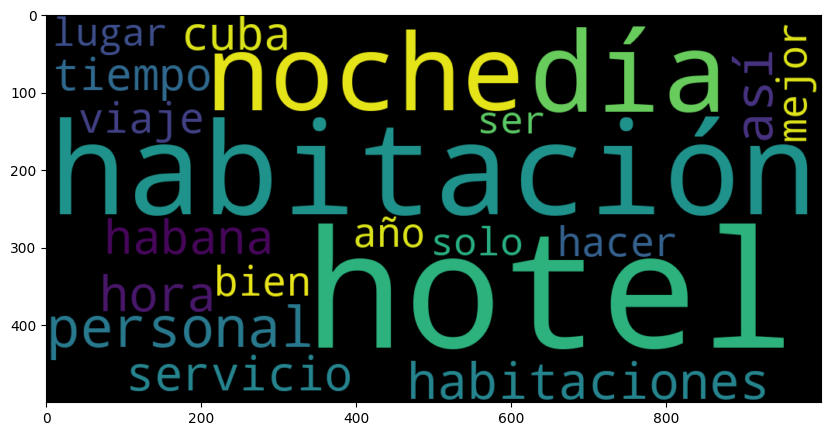

In [174]:
#word cloud for Class 1 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string1
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Palabras mas comunes en reviews con calificacion 2

In [175]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result2 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 2, 'Review']
reviews_list2 = result2.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list2 = [str(review) for review in reviews_list2]
reviews_string2 = ' '.join(reviews_list2)

<function matplotlib.pyplot.show(close=None, block=None)>

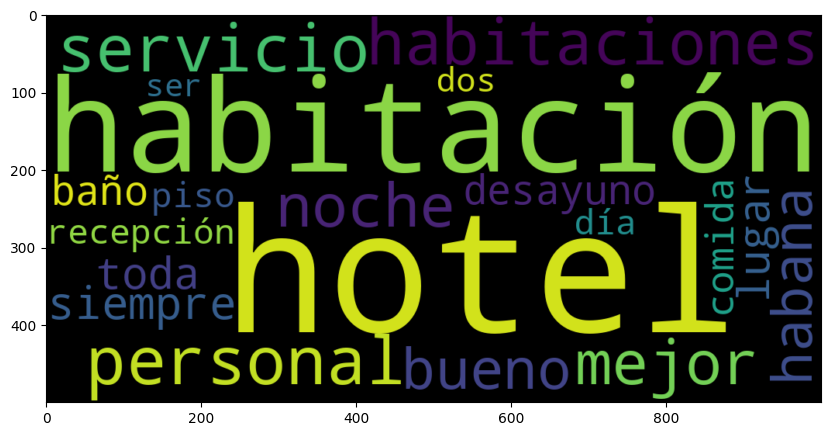

In [176]:
#word cloud for Class 2 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string2
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Palabras mas comunes en reviews con calificacion 3

In [177]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result3 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 3, 'Review']
reviews_list3 = result3.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list3 = [str(review) for review in reviews_list3]
reviews_string3 = ' '.join(reviews_list3)

<function matplotlib.pyplot.show(close=None, block=None)>

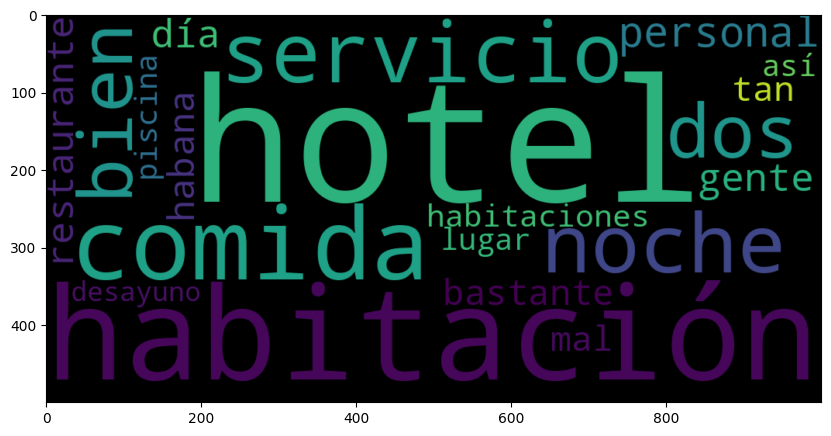

In [178]:
#word cloud for Class 3 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string3
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Palabras mas comunes en reviews con calificacion 4

In [179]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result4 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 4, 'Review']
reviews_list4 = result4.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list4 = [str(review) for review in reviews_list4]
reviews_string4 = ' '.join(reviews_list4)

<function matplotlib.pyplot.show(close=None, block=None)>

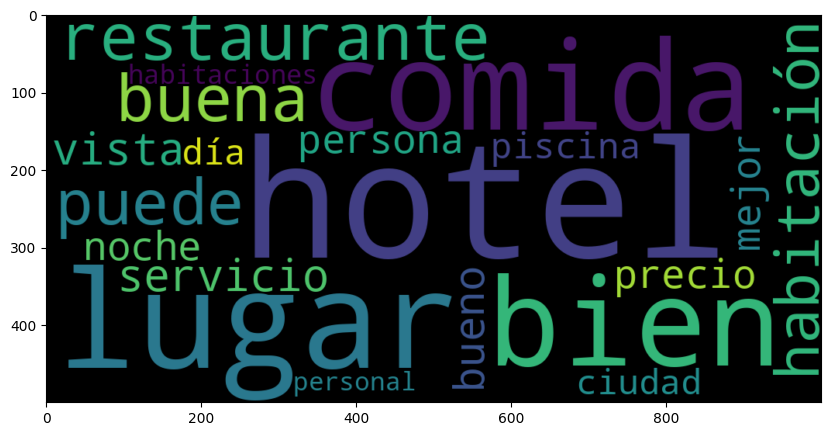

In [180]:
#word cloud for Class 4 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string4
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Palabras mas comunes en reviews con calificacion 5

In [181]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result5 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 5, 'Review']
reviews_list5 = result5.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list5 = [str(review) for review in reviews_list5]
reviews_string5 = ' '.join(reviews_list5)

<function matplotlib.pyplot.show(close=None, block=None)>

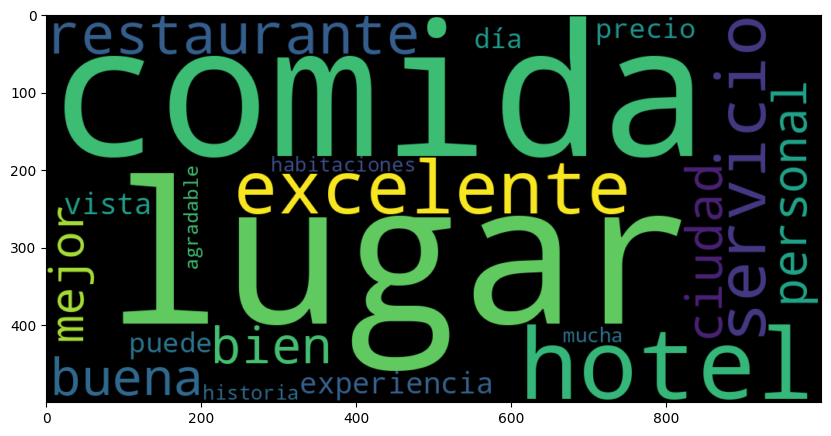

In [182]:
#word cloud for Class 5 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string5
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Diagrama de torta de la distribucion de las review segun su calificacion

In [201]:
reviews_prueba_df['Class'].value_counts()

Class
4    781
5    745
3    121
1     53
2     50
Name: count, dtype: int64

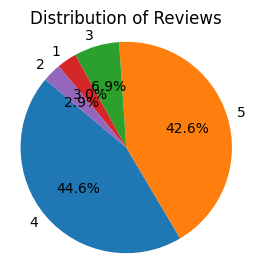

In [202]:
# Plotting
plt.figure(figsize=(3, 3))
plt.pie(reviews_prueba_df['Class'].value_counts(), labels=['4','5','3','1','2'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Reviews')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Showing plot
plt.show()

## 3.2 Randomforest Approach

In [207]:
X_train, X_test, y_train, y_test = train_test_split(reviews_df["Review"], reviews_df['Class'], test_size=0.2, random_state=42)

In [210]:
pipeline_rf = Pipeline([('vectorizer', CountVectorizer()), ('classifier', RandomForestClassifier(n_estimators=50, criterion="entropy"))])
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', n_estimators=50))])

###3.2.1 Analisis de los resultados

Podemos ver que este es un modelo muy bueno ya que  tiene un f1-score, recall y precision de 1 lo cual predice muy bien las reviews.

In [209]:
print(pipeline_rf.score(X_train, y_train))
y_pred_rf = pipeline_rf.predict(X_train)
print("Random Forest Classifier Results:")
print(classification_report(y_train, y_pred_rf))


1.0
Random Forest Classifier Results:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       650
           2       1.00      1.00      1.00       947
           3       1.00      1.00      1.00      1249
           4       1.00      1.00      1.00      1582
           5       1.00      1.00      1.00      1872

    accuracy                           1.00      6300
   macro avg       1.00      1.00      1.00      6300
weighted avg       1.00      1.00      1.00      6300



### 3.2.2 Particion Prueba usando modelo RandomForest Classifier para la clasificacion del documento.

In [211]:
reviews_prueba_df = pd.read_csv("particion_prueba_estudiantes.csv")
reviews_prueba_df

Review
0     La primera noche nos encontramos en la habitac...
1     A una calle de catedral con platillos tradicio...
2     Porciones muy miserables\nAgua con sabor a clo...
3     Cartagena encanta. De todas las ciudades colon...
4     Ibamos con mucha ilusion de disfrutar el espec...
...                                                 ...
1745  Subir en funicular y bajar en teleferico fue u...
1746  La gente espera el lugar central en La Habana,...
1747  Todo excelente con el hotel: las albercas para...
1748  Nos detuvimos en un bocado antes de la puesta ...
1749  NO TENIA AGUA, el mantenimiento un desastre ( ...

[1750 rows x 1 columns]

In [212]:
reviews_prueba_df['Class']=pipeline_rf.predict(reviews_prueba_df['Review'])

In [213]:
reviews_prueba_df

Review  Class
0     La primera noche nos encontramos en la habitac...      1
1     A una calle de catedral con platillos tradicio...      4
2     Porciones muy miserables\nAgua con sabor a clo...      5
3     Cartagena encanta. De todas las ciudades colon...      5
4     Ibamos con mucha ilusion de disfrutar el espec...      4
...                                                 ...    ...
1745  Subir en funicular y bajar en teleferico fue u...      5
1746  La gente espera el lugar central en La Habana,...      3
1747  Todo excelente con el hotel: las albercas para...      5
1748  Nos detuvimos en un bocado antes de la puesta ...      5
1749  NO TENIA AGUA, el mantenimiento un desastre ( ...      2

[1750 rows x 2 columns]

In [217]:
reviews_prueba_df.to_csv('Review:clasifiedRandomforest.csv', index=False)

###3.2.3 Graficos

### Palabras mas comunes en reviews con calificacion 1

In [218]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result1 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 1, 'Review']
reviews_list1 = result1.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list1 = [str(review) for review in reviews_list1]
reviews_string1 = ' '.join(reviews_list1)

<function matplotlib.pyplot.show(close=None, block=None)>

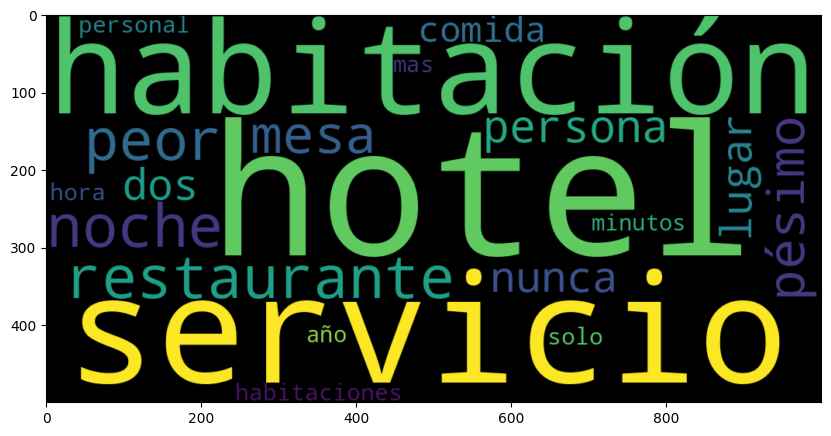

In [219]:
#word cloud for Class 1 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string1
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Palabras mas comunes en reviews con calificacion 2

In [220]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result2 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 2, 'Review']
reviews_list2 = result2.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list2 = [str(review) for review in reviews_list2]
reviews_string2 = ' '.join(reviews_list2)

<function matplotlib.pyplot.show(close=None, block=None)>

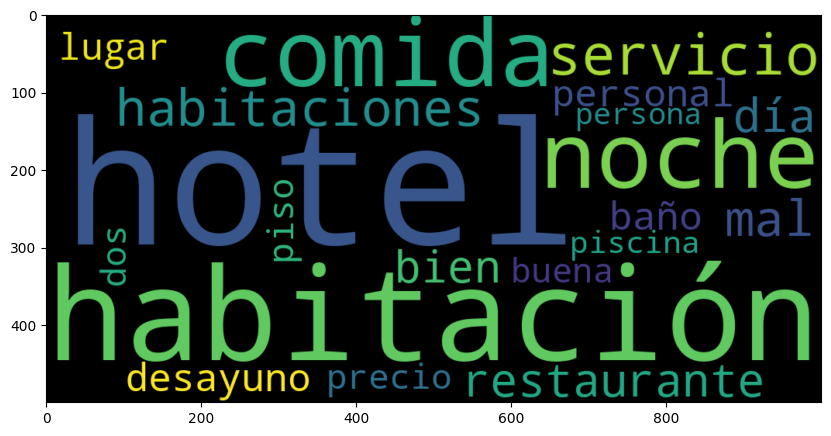

In [221]:
#word cloud for Class 2 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string2
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Palabras mas comunes en reviews con calificacion 3

In [222]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result3 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 3, 'Review']
reviews_list3 = result3.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list3 = [str(review) for review in reviews_list3]
reviews_string3 = ' '.join(reviews_list3)

<function matplotlib.pyplot.show(close=None, block=None)>

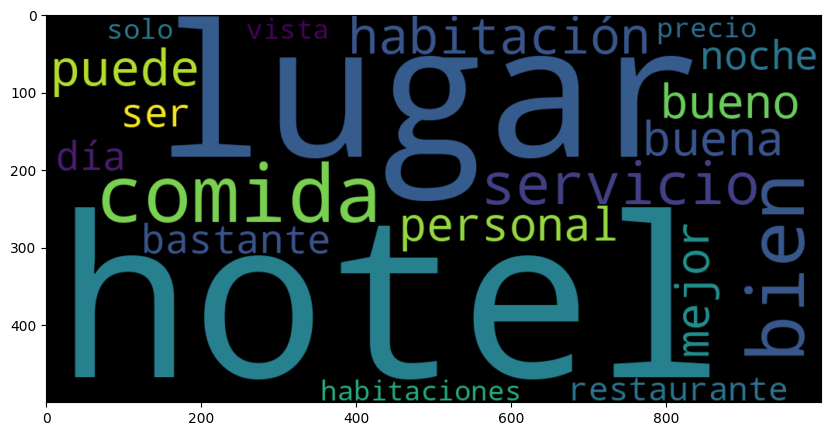

In [223]:
#word cloud for Class 3 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string3
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Palabras mas comunes en reviews con calificacion 4

In [224]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result4 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 4, 'Review']
reviews_list4 = result4.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list4 = [str(review) for review in reviews_list4]
reviews_string4 = ' '.join(reviews_list4)

<function matplotlib.pyplot.show(close=None, block=None)>

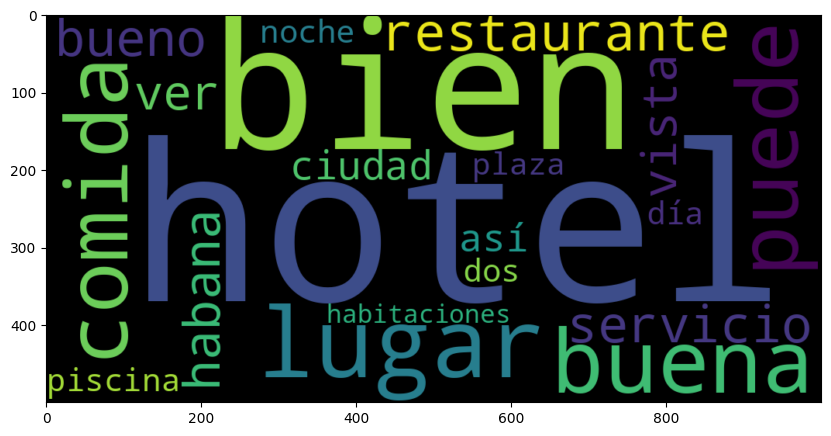

In [225]:
#word cloud for Class 4 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string4
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Palabras mas comunes en reviews con calificacion 5

In [226]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result5 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 5, 'Review']
reviews_list5 = result5.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list5 = [str(review) for review in reviews_list5]
reviews_string5 = ' '.join(reviews_list5)

<function matplotlib.pyplot.show(close=None, block=None)>

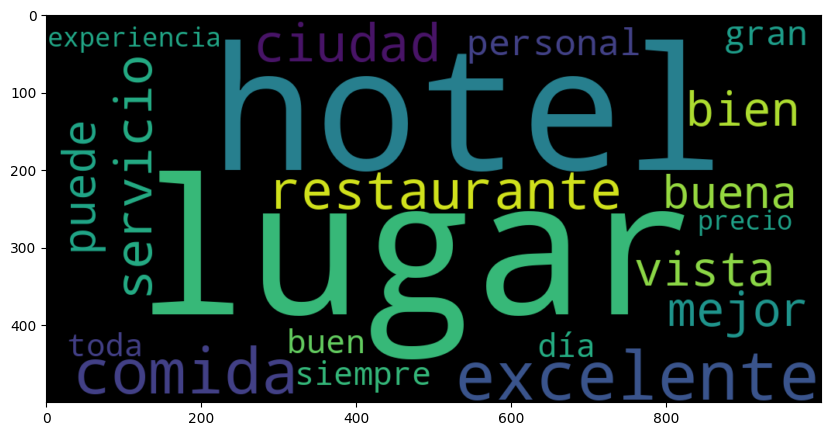

In [227]:
#word cloud for Class 5 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string5
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Diagrama de torta de la distribucion de las review segun su calificacion

In [228]:
reviews_prueba_df['Class'].value_counts()

Class
5    827
4    352
3    287
2    220
1     64
Name: count, dtype: int64

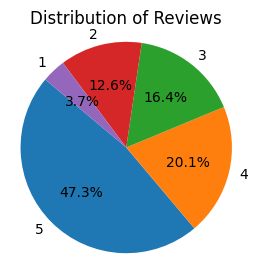

In [230]:
# Plotting
plt.figure(figsize=(3, 3))
plt.pie(reviews_prueba_df['Class'].value_counts(), labels=['5','4','3','2','1'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Reviews')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Showing plot
plt.show()

## 3.3 Multinomial Naive Bayes Classifier

In [231]:
X_train, X_test, y_train, y_test = train_test_split(reviews_df["Review"], reviews_df['Class'], test_size=0.2, random_state=42)

In [232]:
pipeline_nb = Pipeline([('vectorizer', CountVectorizer()), ('classifier', MultinomialNB())])
pipeline_nb.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

### 3.3.1 Analisis de los resultados

Podemos ver que este es un modelo muy bueno ya que tiene un f1-score, recall y precision de 0.85 lo cual predice muy bien las reviews sin embargo es un poco peor que los modelos que utilizan RandomForest o un modelo logistico de regresion.

In [233]:
y_pred_nb = pipeline_nb.predict(X_train)
print("Multinomial Naive Bayes Classifier Results:")
print(classification_report(y_train, y_pred_nb))

Multinomial Naive Bayes Classifier Results:
              precision    recall  f1-score   support

           1       0.98      0.77      0.87       650
           2       0.88      0.83      0.85       947
           3       0.88      0.78      0.82      1249
           4       0.78      0.86      0.82      1582
           5       0.84      0.93      0.88      1872

    accuracy                           0.85      6300
   macro avg       0.87      0.83      0.85      6300
weighted avg       0.85      0.85      0.85      6300



### 3.3.2 Particion Prueba usando modelo Multinomial Naive Bayes Classifier para la clasificacion del documento.

In [234]:
reviews_prueba_df = pd.read_csv("particion_prueba_estudiantes.csv")
reviews_prueba_df

Review
0     La primera noche nos encontramos en la habitac...
1     A una calle de catedral con platillos tradicio...
2     Porciones muy miserables\nAgua con sabor a clo...
3     Cartagena encanta. De todas las ciudades colon...
4     Ibamos con mucha ilusion de disfrutar el espec...
...                                                 ...
1745  Subir en funicular y bajar en teleferico fue u...
1746  La gente espera el lugar central en La Habana,...
1747  Todo excelente con el hotel: las albercas para...
1748  Nos detuvimos en un bocado antes de la puesta ...
1749  NO TENIA AGUA, el mantenimiento un desastre ( ...

[1750 rows x 1 columns]

In [235]:
reviews_prueba_df['Class']=pipeline_nb.predict(reviews_prueba_df['Review'])

In [236]:
reviews_prueba_df

Review  Class
0     La primera noche nos encontramos en la habitac...      2
1     A una calle de catedral con platillos tradicio...      5
2     Porciones muy miserables\nAgua con sabor a clo...      2
3     Cartagena encanta. De todas las ciudades colon...      5
4     Ibamos con mucha ilusion de disfrutar el espec...      4
...                                                 ...    ...
1745  Subir en funicular y bajar en teleferico fue u...      5
1746  La gente espera el lugar central en La Habana,...      3
1747  Todo excelente con el hotel: las albercas para...      5
1748  Nos detuvimos en un bocado antes de la puesta ...      2
1749  NO TENIA AGUA, el mantenimiento un desastre ( ...      2

[1750 rows x 2 columns]

In [237]:
reviews_prueba_df.to_csv('Review:clasifiedMultinomialNaiveBayes.csv', index=False)

### 3.3.3 Graficos

### Palabras mas comunes en reviews con calificacion 1

In [239]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result1 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 1, 'Review']
reviews_list1 = result1.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list1 = [str(review) for review in reviews_list1]
reviews_string1 = ' '.join(reviews_list1)

<function matplotlib.pyplot.show(close=None, block=None)>

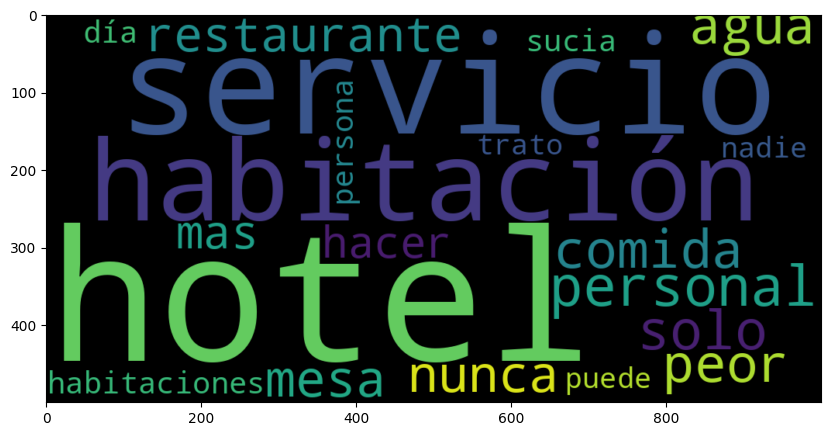

In [240]:
#word cloud for Class 1 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string1
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Palabras mas comunes en reviews con calificacion 2

In [241]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result2 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 2, 'Review']
reviews_list2 = result2.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list2 = [str(review) for review in reviews_list2]
reviews_string2 = ' '.join(reviews_list2)

<function matplotlib.pyplot.show(close=None, block=None)>

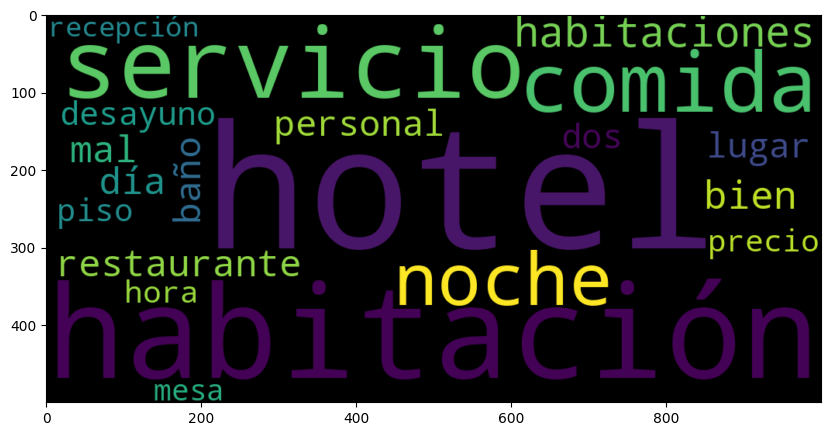

In [242]:
#word cloud for Class 2 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string2
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Palabras mas comunes en reviews con calificacion 3

In [243]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result3 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 3, 'Review']
reviews_list3 = result3.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list3 = [str(review) for review in reviews_list3]
reviews_string3 = ' '.join(reviews_list3)

<function matplotlib.pyplot.show(close=None, block=None)>

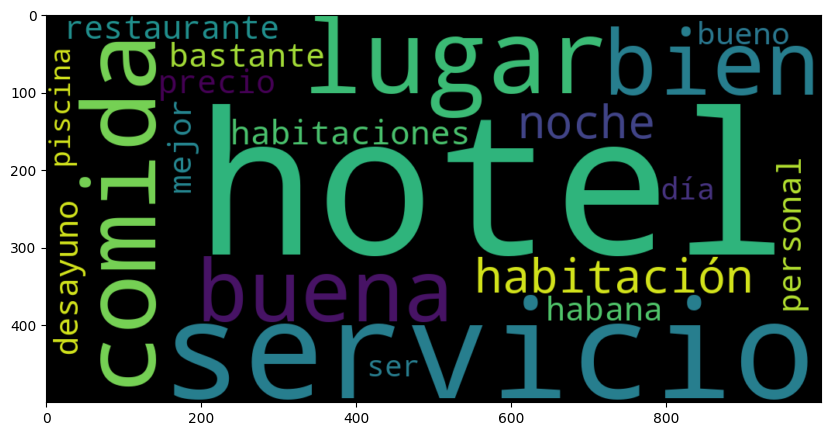

In [244]:
#word cloud for Class 3 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string3
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Palabras mas comunes en reviews con calificacion 4

In [245]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result4 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 4, 'Review']
reviews_list4 = result4.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list4 = [str(review) for review in reviews_list4]
reviews_string4 = ' '.join(reviews_list4)

<function matplotlib.pyplot.show(close=None, block=None)>

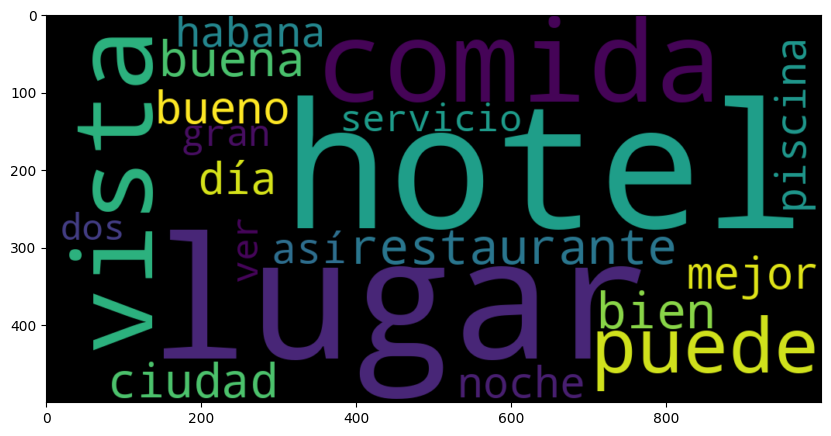

In [246]:
#word cloud for Class 4 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string4
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Palabras mas comunes en reviews con calificacion 5

In [247]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result5 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 5, 'Review']
reviews_list5 = result5.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list5 = [str(review) for review in reviews_list5]
reviews_string5 = ' '.join(reviews_list5)

<function matplotlib.pyplot.show(close=None, block=None)>

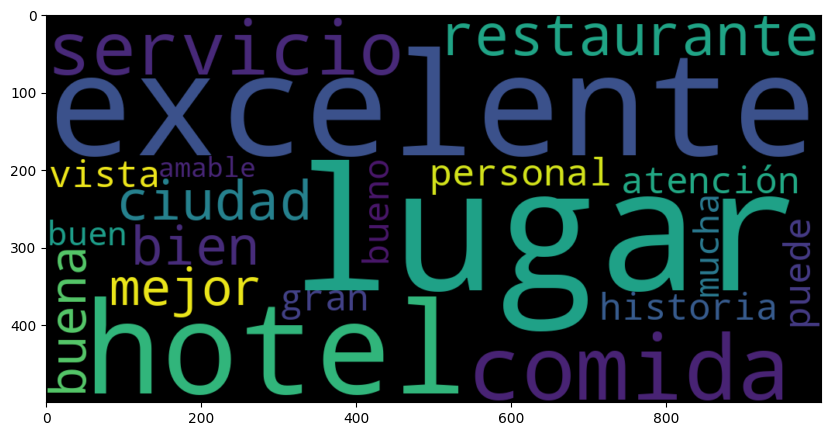

In [248]:
#word cloud for Class 5 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string5
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Diagrama de torta de la distribucion de las review segun su calificacion

In [238]:
reviews_prueba_df['Class'].value_counts()

Class
5    579
4    564
3    275
2    271
1     61
Name: count, dtype: int64

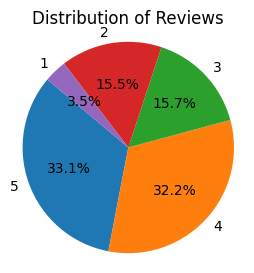

In [249]:
# Plotting
plt.figure(figsize=(3, 3))
plt.pie(reviews_prueba_df['Class'].value_counts(), labels=['5','4','3','2','1'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Reviews')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Showing plot
plt.show()

## 3.4 K-Nearest Neighbors Classifier

In [43]:
X_train, X_test, y_train, y_test = train_test_split(reviews_df["Review"], reviews_df['Class'], test_size=0.2, random_state=42)

In [250]:
pipeline_knn = Pipeline([('vectorizer', CountVectorizer()), ('classifier', KNeighborsClassifier(n_neighbors=10, metric="euclidean"))])
pipeline_knn.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=10))])

### 3.4.1 Analisis de los resultados

Podemos ver que este es un modelo muy malo ya que  tiene un f1-score, recall y precision de 0.43 lo cual predice de manera muy mala las reviews.

In [251]:
y_pred_knn = pipeline_knn.predict(X_train)
print("K-Nearest Neighbors Classifier Results:")
print(classification_report(y_train, y_pred_knn))

K-Nearest Neighbors Classifier Results:
              precision    recall  f1-score   support

           1       0.76      0.12      0.21       650
           2       0.74      0.13      0.22       947
           3       0.31      0.70      0.42      1249
           4       0.51      0.32      0.39      1582
           5       0.52      0.60      0.56      1872

    accuracy                           0.43      6300
   macro avg       0.57      0.37      0.36      6300
weighted avg       0.53      0.43      0.40      6300



### 3.4.2 Particion Prueba usando modelo K-Nearest Neighbors Classifier para la clasificacion del documento.

In [252]:
reviews_prueba_df = pd.read_csv("particion_prueba_estudiantes.csv")
reviews_prueba_df

Review
0     La primera noche nos encontramos en la habitac...
1     A una calle de catedral con platillos tradicio...
2     Porciones muy miserables\nAgua con sabor a clo...
3     Cartagena encanta. De todas las ciudades colon...
4     Ibamos con mucha ilusion de disfrutar el espec...
...                                                 ...
1745  Subir en funicular y bajar en teleferico fue u...
1746  La gente espera el lugar central en La Habana,...
1747  Todo excelente con el hotel: las albercas para...
1748  Nos detuvimos en un bocado antes de la puesta ...
1749  NO TENIA AGUA, el mantenimiento un desastre ( ...

[1750 rows x 1 columns]

In [255]:
reviews_prueba_df['Class']=pipeline_knn.predict(reviews_prueba_df['Review'])

In [256]:
reviews_prueba_df

Review  Class
0     La primera noche nos encontramos en la habitac...      5
1     A una calle de catedral con platillos tradicio...      4
2     Porciones muy miserables\nAgua con sabor a clo...      3
3     Cartagena encanta. De todas las ciudades colon...      5
4     Ibamos con mucha ilusion de disfrutar el espec...      5
...                                                 ...    ...
1745  Subir en funicular y bajar en teleferico fue u...      5
1746  La gente espera el lugar central en La Habana,...      3
1747  Todo excelente con el hotel: las albercas para...      5
1748  Nos detuvimos en un bocado antes de la puesta ...      3
1749  NO TENIA AGUA, el mantenimiento un desastre ( ...      3

[1750 rows x 2 columns]

In [257]:
reviews_prueba_df.to_csv('Review:clasifiedK-NearestNeighborsClassifier.csv', index=False)

### 3.4.3 Graficos

### Palabras mas comunes en reviews con calificacion 1

In [259]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result1 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 1, 'Review']
reviews_list1 = result1.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list1 = [str(review) for review in reviews_list1]
reviews_string1 = ' '.join(reviews_list1)

<function matplotlib.pyplot.show(close=None, block=None)>

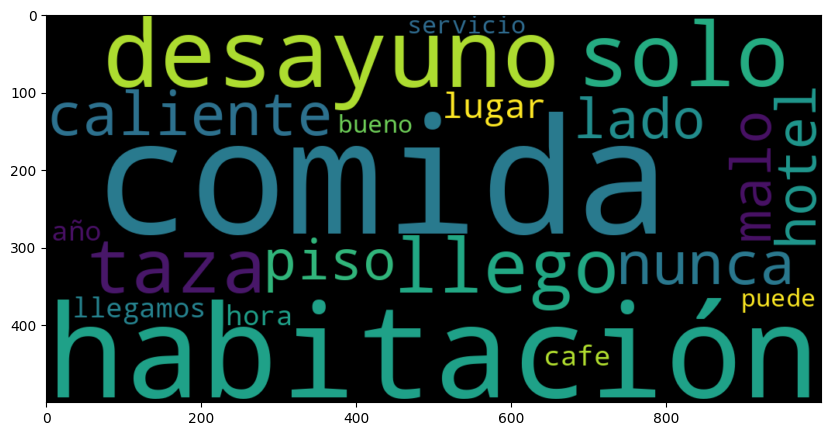

In [260]:
#word cloud for Class 1 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string1
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Palabras mas comunes en reviews con calificacion 2

In [261]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result2 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 2, 'Review']
reviews_list2 = result2.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list2 = [str(review) for review in reviews_list2]
reviews_string2 = ' '.join(reviews_list2)

<function matplotlib.pyplot.show(close=None, block=None)>

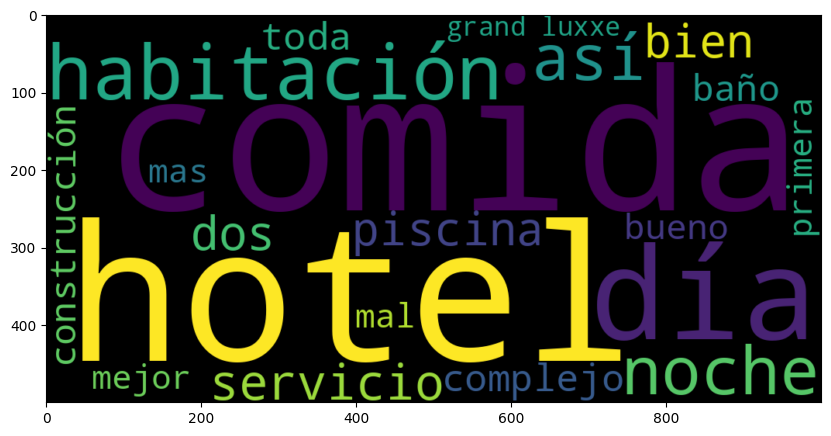

In [262]:
#word cloud for Class 2 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string2
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Palabras mas comunes en reviews con calificacion 3

In [263]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result3 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 3, 'Review']
reviews_list3 = result3.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list3 = [str(review) for review in reviews_list3]
reviews_string3 = ' '.join(reviews_list3)

<function matplotlib.pyplot.show(close=None, block=None)>

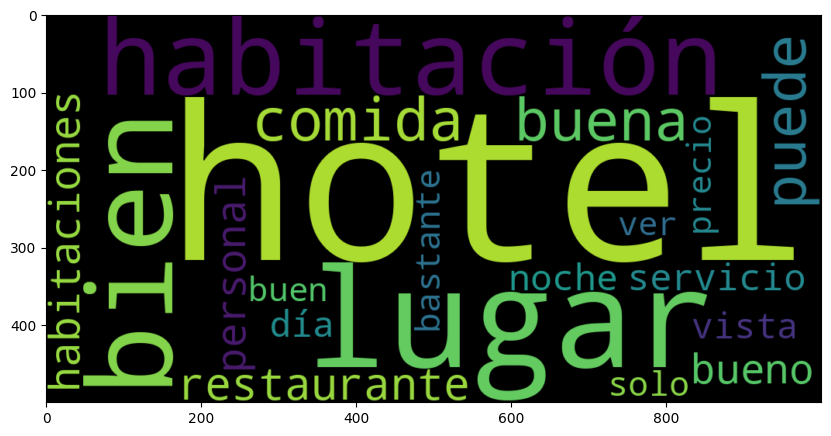

In [264]:
#word cloud for Class 3 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string3
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Palabras mas comunes en reviews con calificacion 4

In [265]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result4 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 4, 'Review']
reviews_list4 = result4.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list4 = [str(review) for review in reviews_list4]
reviews_string4 = ' '.join(reviews_list4)

<function matplotlib.pyplot.show(close=None, block=None)>

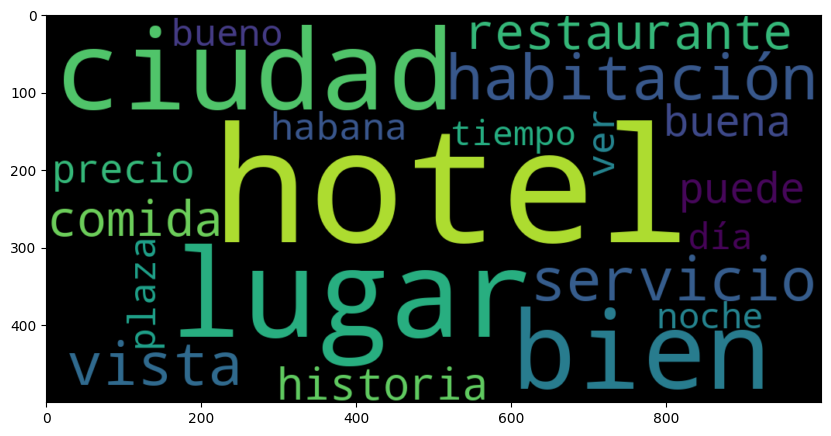

In [266]:
#word cloud for Class 4 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string4
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Palabras mas comunes en reviews con calificacion 5

In [267]:
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(preprocessor)
reviews_prueba_df['Review'] = reviews_prueba_df['Review'].apply(tokenizer)
result5 = reviews_prueba_df.loc[reviews_prueba_df['Class'] == 5, 'Review']
reviews_list5 = result5.tolist()

# Conviertes cada elemento de la lista en un string si no lo es ya
reviews_list5 = [str(review) for review in reviews_list5]
reviews_string5 = ' '.join(reviews_list5)

<function matplotlib.pyplot.show(close=None, block=None)>

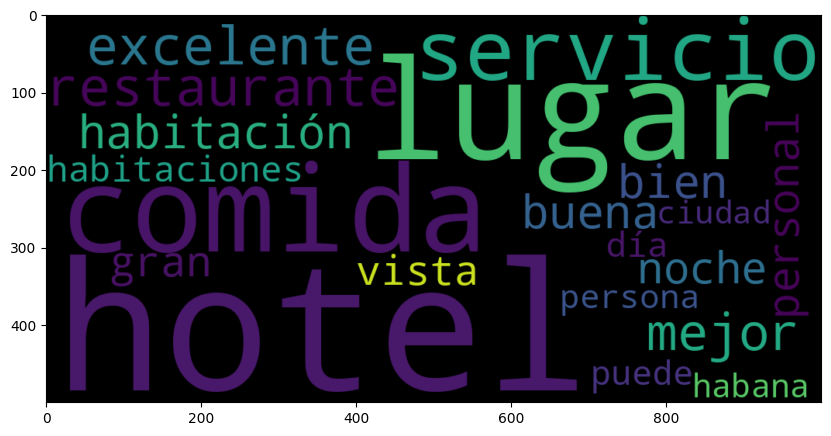

In [268]:
#word cloud for Class 5 review words
plt.figure(figsize=(10,10))
negative_text=reviews_string5
WC=WordCloud(width=1000,height=500,max_words=20,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Diagrama de torta de la distribucion de las review segun su calificacion

In [258]:
reviews_prueba_df['Class'].value_counts()

Class
3    839
5    614
4    256
2     25
1     16
Name: count, dtype: int64

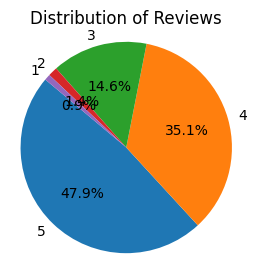

In [269]:
# Plotting
plt.figure(figsize=(3, 3))
plt.pie(reviews_prueba_df['Class'].value_counts(), labels=['5','4','3','2','1'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Reviews')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Showing plot
plt.show()